## **LSTM za predikciju peludi u zraku**

In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **Data loading**

Učitavanje iz mape na računalu

In [2]:
from google.colab import files
uploaded = files.upload()

Saving real_for_all_NS_2000_2021.csv to real_for_all_NS_2000_2021.csv


In [3]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['real_for_all_NS_2000_2021.csv']))
data = df2.drop(['LOK','DAT'], axis=1)

In [4]:
data = pd.read_csv("real_for_all_NS_2000_2021.csv")
data = data.drop(['LOK','DAT'], axis=1)


In [5]:
data

,RA,SN,TS,FG,MBV,SBV,PAD,VLZ,ATT,MNT,MKT,SRT,GOD,MSC,DAN,RBD,PRAM,PRBR,PRTR
0,0.0,0.0,0.0,0.0,14.0,12.00,0.0,95.00,1028.0,-4.0,-2.0,-3.0,2000.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,7.0,4.00,0.0,93.00,1030.0,-3.0,-1.0,-1.0,2000.0,1.0,2.0,2.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,7.0,6.00,0.0,93.00,1031.0,-3.0,1.0,-1.0,2000.0,1.0,3.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,11.0,5.00,0.0,97.00,1026.0,-3.0,-1.0,-2.0,2000.0,1.0,4.0,4.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,6.00,0.0,97.00,1026.0,-2.0,-1.0,-1.0,2000.0,1.0,5.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.0,0.0,0.0,0.0,19.0,10.69,19.1,93.29,1012.3,-0.7,0.8,-0.1,2021.0,12.0,27.0,361.0,0.0,0.0,0.0
8032,0.0,0.0,0.0,0.0,14.0,7.65,3.3,95.25,1011.3,-0.1,2.5,1.1,2021.0,12.0,28.0,362.0,0.0,0.0,0.0
8033,0.0,0.0,0.0,0.0,13.0,5.23,3.6,95.04,1010.1,2.3,5.9,4.2,2021.0,12.0,29.0,363.0,0.0,0.0,0.0
8034,0.0,0.0,0.0,0.0,14.0,8.25,2.8,92.44,1021.0,2.3,4.8,3.6,2021.0,12.0,30.0,364.0,0.0,0.0,0.0


In [6]:
X_ambrozija = pd.concat([data.iloc[:,:16], data['PRAM']], axis = 1)
X_breza = pd.concat([data.iloc[:,:16], data['PRBR']], axis = 1)
X_trava = pd.concat([data.iloc[:,:16], data['PRTR']], axis = 1)


In [7]:
X_ambrozija

,RA,SN,TS,FG,MBV,SBV,PAD,VLZ,ATT,MNT,MKT,SRT,GOD,MSC,DAN,RBD,PRAM
0,0.0,0.0,0.0,0.0,14.0,12.00,0.0,95.00,1028.0,-4.0,-2.0,-3.0,2000.0,1.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,7.0,4.00,0.0,93.00,1030.0,-3.0,-1.0,-1.0,2000.0,1.0,2.0,2.0,0.0
2,0.0,0.0,0.0,0.0,7.0,6.00,0.0,93.00,1031.0,-3.0,1.0,-1.0,2000.0,1.0,3.0,3.0,0.0
3,0.0,0.0,0.0,1.0,11.0,5.00,0.0,97.00,1026.0,-3.0,-1.0,-2.0,2000.0,1.0,4.0,4.0,0.0
4,0.0,0.0,0.0,1.0,11.0,6.00,0.0,97.00,1026.0,-2.0,-1.0,-1.0,2000.0,1.0,5.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.0,0.0,0.0,0.0,19.0,10.69,19.1,93.29,1012.3,-0.7,0.8,-0.1,2021.0,12.0,27.0,361.0,0.0
8032,0.0,0.0,0.0,0.0,14.0,7.65,3.3,95.25,1011.3,-0.1,2.5,1.1,2021.0,12.0,28.0,362.0,0.0
8033,0.0,0.0,0.0,0.0,13.0,5.23,3.6,95.04,1010.1,2.3,5.9,4.2,2021.0,12.0,29.0,363.0,0.0
8034,0.0,0.0,0.0,0.0,14.0,8.25,2.8,92.44,1021.0,2.3,4.8,3.6,2021.0,12.0,30.0,364.0,0.0


# **Preparing data**

In [14]:
X_ambrozija_filtered = X_ambrozija.loc[(X_ambrozija['MSC'] >= 6.0) & (X_ambrozija['MSC'] <= 11.0)]

mm = MinMaxScaler()

#X_ambrozija_mm = mm.fit_transform(X_ambrozija_filtered)
X_ambrozija_mm = mm.fit_transform(X_ambrozija)
X_breza_mm = mm.fit_transform(X_breza)
X_trava_mm = mm.fit_transform(X_trava)


In [9]:
print(X_ambrozija_mm.shape)
X_ambrozija_mm

(8036, 17)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.03333333, 0.00273973,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.00547945,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.93333333, 0.99178082,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.96666667, 0.99452055,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99726027,
        0.        ]])

In [15]:
number_of_days = 5
percentage = 0.7
sample = int(len(X_ambrozija_mm) * percentage)

X_list=[]
y_list=[]
for i in range(len(X_ambrozija_mm) - number_of_days):

    X_list.append(X_ambrozija_mm[i:i+number_of_days])
    y_list.append(X_ambrozija_mm[i+number_of_days][16])

X = np.array(X_list)
y = np.array(y_list)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (4021, 5, 17)
y shape:  (4021,)


In [16]:
X_train_numpy = X[:sample]
X_test_numpy = X[sample:]

X_train = torch.from_numpy(X_train_numpy).to(device)
X_test = torch.from_numpy(X_test_numpy).to(device)

y_train_numpy = y[:sample]
y_test_numpy = y[sample:]

y_train = torch.from_numpy(y_train_numpy).to(device)
y_test = torch.from_numpy(y_test_numpy).to(device)

print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

X train shape:  torch.Size([2818, 5, 17])
X test shape:  torch.Size([1203, 5, 17])
y train shape:  torch.Size([2818])
y test shape:  torch.Size([1203])


# **Creating model**

In [17]:
input_size = X_train.shape[2]

hidden_size = 512

model = nn.LSTM(input_size, hidden_size).to(device)

dropout = nn.Dropout(p=0.25)
transform = nn.Linear(hidden_size,1).to(device)

learning_rate = 0.01
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = torch.nn.MSELoss()

# **Training model**

In [18]:
model.train()
model.float()
loss_iteracije = []
loss_epohe = []

for epoch in tqdm(range(1,epochs+1)):

    for interval in range(X_train.shape[0]):

        output, (hn, cn) = model(X_train[interval].float())

        dropout_out = dropout(hn)

        fin_out = transform(dropout_out)

        optimizer.zero_grad()

        loss = criterion(fin_out[0][0], y_train[interval].float())
        loss.backward()

        optimizer.step()

        loss_iteracije.append(loss.item())

        if epoch % (round(epochs * 0.1)) == 0 and interval == (X_train.shape[0]-1):
            print("Epoch:", epoch, ",  loss:", loss.item())
    loss_epohe.append(loss.item())



 10%|█         | 20/200 [02:02<18:13,  6.08s/it]

Epoch: 20 ,  loss: 0.011339318938553333


 20%|██        | 40/200 [04:00<15:50,  5.94s/it]

Epoch: 40 ,  loss: 0.01408419106155634


 30%|███       | 60/200 [05:59<13:47,  5.91s/it]

Epoch: 60 ,  loss: 0.0007396150031127036


 40%|████      | 80/200 [07:58<11:55,  5.96s/it]

Epoch: 80 ,  loss: 0.00015900204016361386


 50%|█████     | 100/200 [09:56<09:59,  6.00s/it]

Epoch: 100 ,  loss: 0.0012010085629299283


 60%|██████    | 120/200 [11:54<07:53,  5.92s/it]

Epoch: 120 ,  loss: 0.0006833642837591469


 70%|███████   | 140/200 [13:53<05:54,  5.90s/it]

Epoch: 140 ,  loss: 0.0006925179623067379


 80%|████████  | 160/200 [15:51<03:58,  5.96s/it]

Epoch: 160 ,  loss: 7.853656279621646e-05


 90%|█████████ | 180/200 [17:50<01:58,  5.91s/it]

Epoch: 180 ,  loss: 6.717601053196631e-08


100%|██████████| 200/200 [19:49<00:00,  5.95s/it]

Epoch: 200 ,  loss: 0.0016366189811378717


# Save model

Save model

In [ ]:
#1
file_name_state_dict = 'modelDict.pth'
torch.save(model.state_dict(), file_name_state_dict)
files.download(file_name_state_dict)

#2
file_name_model = 'model.pth'
torch.save(model, file_name_model)
files.download(file_name_model)

#3
file_name_scripted = 'model_scripted.pt'
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(file_name_scripted) # Save
files.download(file_name_scripted)


checkpoint = {'input_size': input_size,
              'hidden_size': hidden_size,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')
files.download('checkpoint.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Testing model**

In [19]:
model.eval()

all_predictions = []

with torch.no_grad():
    for x in X_test:
        output, (hn, cn) = model(x.float())

        predict = transform(hn).detach().item()

        all_predictions.append(predict)

y_predict = np.array(all_predictions)



In [20]:
from sklearn.metrics import explained_variance_score


def save_model_info(number_of_days, mm, percentage, X_train, y_train, X_test, y_test, hidden_size, transform, learning_rate, epochs, optimizer, criterion, y_test_numpy, y_predict):
    with open('model_info.txt', 'w') as f:
        f.write("Ambrozija\n \n")
        f.write("Sequence (broj dana) je " + str(number_of_days) + "\n \n")
        f.write("Za skaliranje podataka je korišten " + str(mm) + "\n \n")
        f.write("Podjela podataka:\n")
        f.write("- treniranje: " + str(percentage) +", X = " + str(X_train.shape) +", y = "+ str(y_train.shape) + "\n")
        f.write("- testiranje: " + str(round(1 - percentage, 2)) +", X = " + str(X_test.shape) +", y = "+ str(y_test.shape) + "\n \n")
        f.write("Podatci za LSTM model:\n")
        f.write("- input size = " + str(X_train.shape[2]) + "\n")
        f.write("- hidden size = " + str(hidden_size) + "\n")
        f.write("- transform = " + str(transform) + "\n")
        f.write("- learing rate = " + str(learning_rate) + "\n")
        f.write("- epochs = " + str(epochs) + "\n")
        f.write("- optimizer = " + str(optimizer) + "\n")
        f.write("- criterion = " + str(criterion) + "\n \n")
        f.write("Usporedba predikcije i stvarnih rezultata: \n")
        f.write("- explained variance regression score function: " + str(explained_variance_score(y_test_numpy, y_predict)) + "\n")
        f.write("Dropout - " + str(dropout) + "\n")




save_model_info(number_of_days, mm, percentage, X_train, y_train, X_test, y_test, hidden_size, transform, learning_rate, epochs, optimizer, criterion, y_test_numpy, y_predict)

# **Plotting data**

In [21]:
def plot_graph(x, y, file_name, interval_by_user, color, filter=False):
    fig, ax = plt.subplots()
    ax.set(xlabel='Datumi', ylabel='Koncentracija',
        title='Skalirana koncentracija peludi u zraku kroz 6 godina')
    ax.grid()

    if filter == False:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval_by_user))

    plt.xticks(rotation=60)
    plt.plot(x, y, color)

    if filter == True:
        plt.savefig(file_name + '_filtrirano.png', bbox_inches = 'tight')
        files.download(file_name + "_filtrirano.png")
        plt.savefig(file_name + '_filtrirano.pdf', bbox_inches = 'tight')
        files.download(file_name + "_filtrirano.pdf")
    else:
        plt.savefig(file_name + '.png', bbox_inches = 'tight')
        files.download(file_name + ".png")
        plt.savefig(file_name + '.pdf', bbox_inches = 'tight')
        files.download(file_name + ".pdf")

    plt.show()


def plot_two_graphs(x, y1, y2, file_name, interval_by_user, filter=False, segment=False):

    fig, ax = plt.subplots()


    ax.grid()
    if filter == False:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = interval_by_user))

    plt.xticks(rotation=60)
    plt.plot(x, y1, color='r')
    plt.plot(x, y2, color='b')
    if segment == True:
        ax.set(xlabel='Datumi', ylabel='Koncentracija', title = 'Skalirana koncentracija peludi u zraku kroz 6 mjeseci')
        if filter == True:
            plt.savefig(file_name + '_zajedno_segment_filtrirano' + '.png', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_segment_filtrirano' + ".png")
            plt.savefig(file_name + '_zajedno_segment_filtrirano' + '.pdf', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_segment_filtrirano' + ".pdf")
        else:
            plt.savefig(file_name + '_zajedno_segment' + '.png', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_segment' + ".png")
            plt.savefig(file_name + '_zajedno_segment' + '.pdf', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_segment' + ".pdf")
    else:
        ax.set(xlabel='Datumi', ylabel='Koncentracija', title = 'Skalirana koncentracija peludi u zraku kroz 6 godina')
        if filter == True:
            plt.savefig(file_name + '_zajedno_filtrirano' + '.png', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_filtrirano' + ".png")
            plt.savefig(file_name + '_zajedno_filtrirano' + '.pdf', bbox_inches = 'tight')
            files.download(file_name + '_zajedno_filtrirano' + ".pdf")
        else:
            plt.savefig(file_name + '_zajedno' + '.png', bbox_inches = 'tight')
            files.download(file_name + '_zajedno' + ".png")
            plt.savefig(file_name + '_zajedno' + '.pdf', bbox_inches = 'tight')
            files.download(file_name + '_zajedno' + ".pdf")
    plt.show()


All data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

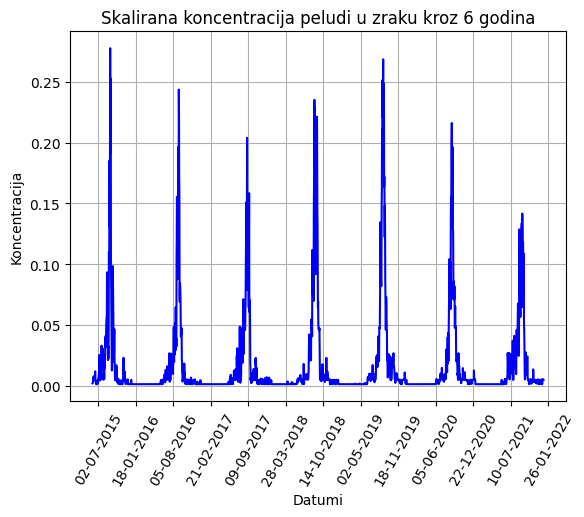

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

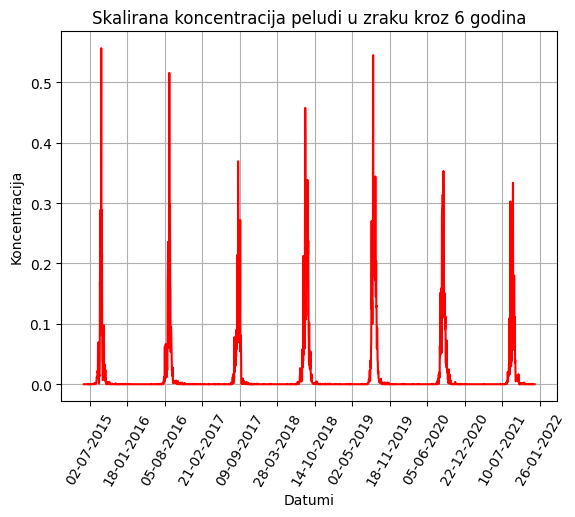

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

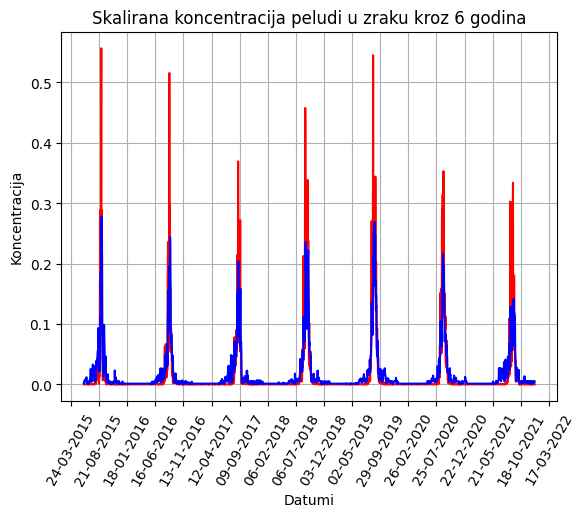

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

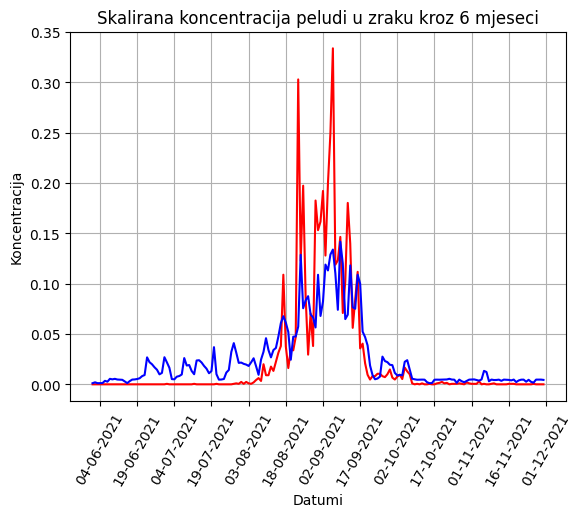

In [ ]:
dates = pd.read_csv("real_for_all_NS_2000_2021.csv")['DAT'].to_numpy()[sample+number_of_days:]
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]


file_name = "epochs_" + str(epochs) + "_sequence_" + str(number_of_days)

# prediction
plot_graph(x_dates, y_predict, file_name + '_prediction', 200, color='b')

# original data
plot_graph(x_dates, y_test_numpy, file_name + '_original', 200, color='r')

# together
plot_two_graphs(x_dates, y_test_numpy, y_predict, file_name, 150)

# together but only for a few months
start_date = x_dates.index(dt.date.fromisoformat('2021-06-01'))
end_date = x_dates.index(dt.date.fromisoformat('2021-12-01'))
x_segment = np.array(x_dates)[start_date:end_date]

plot_two_graphs(x_segment, y_test_numpy[start_date:end_date], y_predict[start_date:end_date], file_name, 15, segment=True)




Filtered data

Kada želimo izabicti period u kojemu  znamo da nema peludi uzimamo podatke od 1.6. pa do 30.11. Tu ima sveukupno 183 dana u jednoj godini, a mi imamo period od 21 godine. Pretvramo datume iz datetime formata u string zato da pri ispisu grafa python ne bi nepotreno ispisao period koji ne gledamo, ako koristimo datetime onda u grafu vidimo period od npr 30.11.2020 do 1.6.2021. koji nas ne zanima, a ni nemamo vrijednosti za prikazati na grafu.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

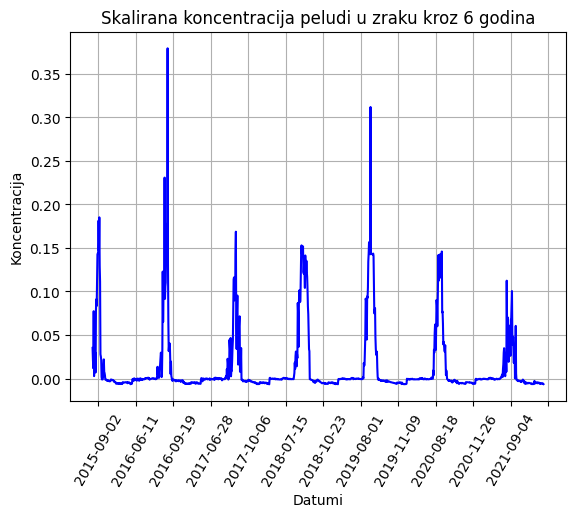

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

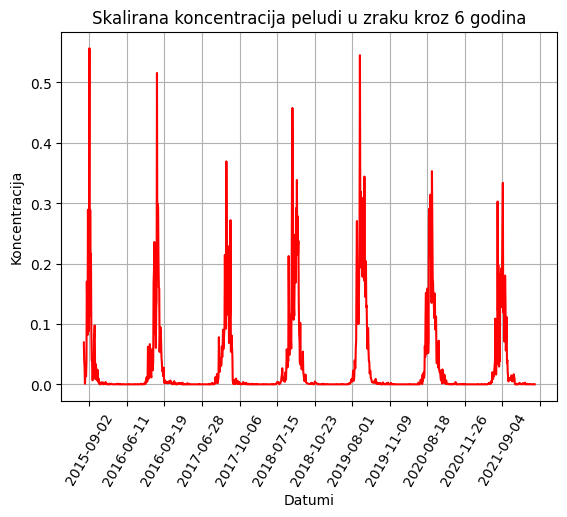

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

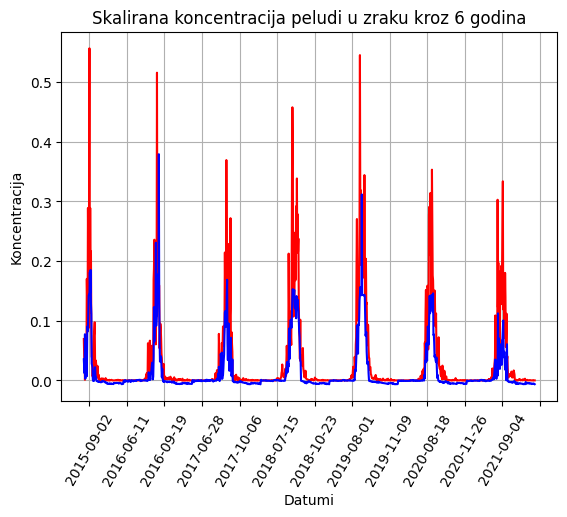

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

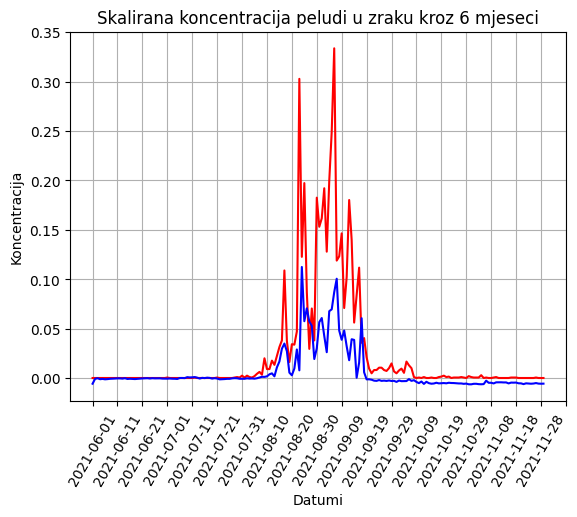

In [22]:
dates = pd.read_csv("real_for_all_NS_2000_2021.csv")[['DAT', 'MSC']]
dates = dates.loc[(dates['MSC'] >= 6.0) & (dates['MSC'] <= 11.0)]['DAT'].to_numpy()

dates_list = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

dates_str_list = []

for date in dates_list:
    dates_str_list.append(str(date))
x_dates = np.array(dates_str_list)[sample+number_of_days:]


file_name = "epochs_" + str(epochs) + "_sequence_" + str(number_of_days)

# prediction
plot_graph(x_dates, y_predict, file_name + '_prediction', 100, color='b', filter=True)

# original data
plot_graph(x_dates, y_test_numpy, file_name + '_original', 100, color='r', filter=True)

# together
plot_two_graphs(x_dates, y_test_numpy, y_predict, file_name, 100, filter=True)

# together but only for a few months
start_date = np.where(x_dates == '2021-06-01')[0][0]
end_date = np.where(x_dates == '2021-11-30')[0][0]

plot_two_graphs(x_dates[start_date:end_date], y_test_numpy[start_date:end_date], y_predict[start_date:end_date], file_name, 10, filter=True, segment=True)
